# About this Notebook

This Jupyter Notebook can be used to replicate the computational experiments and results presented in the following paper

> Paradis, Gregory E. 2019. _A simplified method for estimating stem diameter distributions from horizontal point sample data_. Forestry (submitted).

The code in this notebook is implemented using freely-available open-source software libraries, and should be run using a Python 3 kernel. The notebook can be downloaded from [GitHub](https://github.com/gparadis/hpsdistfit).

# Background

Diameter frequency distributions are a key piece of information describing forest stands, for both practical forestry applications and scientific research on forest ecosystems. A substantial fraction of forest inventory data is collected using horizontal point sampling (HPS) methods. The procedure for deriving diameter distributions from HPS data is clearly described in the literature (e.g., see Ducey and Gove, 2015), but is somewhat complex.

Paradis (2019) presents a simplified method for estimating stem diameter distributions from horizontal point sample data, including a computational experiment showing that output from our method is essentially identical to the more complex reference method. We hope our method will make it easier for practitioners and researchers alike to correctly derive diameter distributions from HPS datasets.

This notebook contains instructions and code that can be used to replicate the computational experiment and results presented in Paradis (2019), as well as constitute a known-working software implementation of the simplified method presented therein.


# Initialization

Load required packages, define global variables, and define some helper functions.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import matplotlib
import matplotlib.font_manager
import math
import scipy.version
from scipy import integrate
from scipy.special import gamma, beta, betaln
from scipy import stats 
#from scipy.ndimage.filters import gaussian_filter1d
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit as _curve_fit
import ipy_table as ipt
import pysal as ps
import geopandas as gpd
import shapely
from scipy.stats.distributions import t
from numpy import zeros, arange
from math import sqrt
import pickle
from functools import partial, wraps
import types
from lmfit import Model, Parameter, MinimizerException
from lmfit.model import ModelResult

pd.set_option('display.max_columns', 10)
sns.set_context('paper', font_scale=1.0)
sns.set_style('white')
#rc('text',usetex=True)
#rc('font',**{'family':'serif','serif':['Computer Modern']})

data_path = './dat/'
size_classes = range(10, 62, 2) # 2 cm DBH classes in range [10, 60]
treatment_types = [1, 2, 3] # 1: clearcut, 2: selection cut, 3: commercial thin
cover_types = ['r', 'm', 'f'] # r: softwood, m: mixedwood, f: hardwood
species_group_names = {'auf':'Other Hardwoods',
                       'boj':'Yellow Birch',
                       'bop':'White Birch',
                       'chce':'Oak-Hickory',
                       'ers':'Sugar Maple',
                       'erx':'Other Maples',
                       'peu':'Poplar',
                       'pib':'Eastern White Pine',
                       'pir':'Red Pine',
                       'sepm':'Fir-Spruce-Pine-Larch',
                       'topu':'Eastern White Cedar'}
cover_type_names = {'r':'Softwood', 
                    'm':'Mixedwood',
                    'f':'Hardwood'}

Define some helper functions that will be used further down.

We use `scipy.optimize.curve_fit`, which can handle a wide range of curve fitting tasks. By default, `curve_fit` calls `scipy.optimize.leastsq` for unbounded problems, which has an optional `maxfev` argument (related to the number of iterations the algorithm will run before giving up and declaring non-convergence) that we need to set to a big number (`curve_fit` throws too many errors with default values). For bounded problems, `curve_fit` calls `scipy.optimize.least_squares`, which has similar optional argument named `max_nfev`. Depending on whether we set bounds on parameter values or not, we need to call `curve_fit` with different keyword argument names (either `max_nfev` or `maxfev`). Therefore, we have to test for boundedness of problem before every call to `curve_fit` to make sure we pass the correct keyword argument name. Yuck. Perhaps `scipy` package maintainers will patch the interface someday to make this work as expected.  

Meanwhile, we can get around all this nonsense by defining a wrapper function for `scipy.optimize.curve_fit` that tests problem boundedness and renames `maxfev` keyword argument to `max_nfev` if the problem is bounded. If called via this wrapper, `curve_fit` now seems to behaves the way it should (i.e. according to the POLA). 

Note that this problem seems to have been [patched](https://github.com/scipy/scipy/commit/eef17945bf0f89344ea9c1ce8ce2ec33f0e401f8) in the `master` branch on GitHub since the latest release of `scipy` (`0.18.1`).

In [2]:
@wraps(_curve_fit)
def curve_fit(*args, **kwargs):
    b = kwargs['bounds'] if 'bounds' in kwargs else None 
    if b and np.any(np.isfinite(b)) and 'max_nfev' not in kwargs:
        kwargs['max_nfev'] = kwargs.pop('maxfev', None)
    return _curve_fit(*args, **kwargs)

Define a helper function that standardizes compilation of a bin centers, bin values, bin edges, and bin standard errors from a `pandas.DataFrame` containing our raw PSP inventory data.

In [3]:
def compile_bin_data(data, bins=None, xminmm=90, xmaxmm=610, xwmm=20, ef=25., alpha=0.05, pid_colname='id_pep', dbh_colname='dhpmm', normed=True, compile_stderr=False):
    #display(data)
    df = data.reset_index().set_index(pid_colname)
    if bins is None:
        bins = np.arange(xminmm, xmaxmm+xwmm, xwmm)

    bin_vals, bin_edges = np.histogram(df[dbh_colname], bins=bins, range=(xminmm, xmaxmm))
    bin_vals = bin_vals * ef # expand to stems/ha
    bin_stderrs = []
    if compile_stderr:
        for i, (xa, xb) in enumerate([(x, x+xwmm) for x in bins[:-1]]):
            #print 'processing bin', i
            Y = []
            for pid in df.index.unique():
                #print i, pid, len(df.index.unique())
                try:
                    _df = df.loc[[pid]].query('%s > %i & %s <= %i' % (dbh_colname, xa, dbh_colname, xb))
                except:
                    print(df.loc[pid]) 
                    raise
                Y.append(len(_df) * ef)
            sigma = sqrt((sum(y**2 for y in Y) - sum(Y)/len(Y))/(len(Y) - 1))
            t = distributions.t.ppf(1. - alpha/2., len(Y) - 1) 
            #print t*sigma
            bin_stderrs.append(t * sigma)
    else:
        bin_stderrs = [0. for i in bin_vals]
    bin_stderrs = np.array(bin_stderrs)
    bin_centers = (bin_edges[:-1] + (xwmm * 0.5)) * 0.1
    if normed: 
        scale = float(0.1 * xwmm * sum(bin_vals))
        bin_vals = bin_vals * pow(scale, -1)
        bin_stderrs = bin_stderrs * pow(scale, -1)
    return bin_centers, bin_vals, bin_edges * 0.1, bin_stderrs

# Note on Inventory Data

The computational experiment implemented in this notebook uses permanent sample data collected in Quebec (Canada). Detailed information on the Quebec PSP inventory program under which our test data was collected is available from the [Ministère des forêts, faune, et parcs (MFFP)](http://mffp.gouv.qc.ca/les-forets/inventaire-ecoforestier/), including technical documentation on inventory methods, data standards, and contact information. The full PSP dataset can be downloaded from [Données Québec](ftp://transfert.mffp.gouv.qc.ca/Public/Diffusion/DonneeGratuite/Foret/DONNEES_FOR_ECO_SUD/Placettes_permanentes/PEP_GDB.zip). 

We preprocessed the full PSP dataset to include only live, merchantable stems from the fourth decennial inventory cycle, from the largest of 8 plot networks, corresponding to mature, undisturbed stands, for which there was valid data in all fields. This notebook loads a pickle file (`dat/misc/tiges_final_full.p`) that contains a serialized `pandas.DataFrame` object created in the preprocessing step. We include filtered dataset here for convenience, and to facilitate reproduction of results presented in Paradis (2019). It is advisable that someone with expert understanding of the statistical limitation of Quebec PSP data be tasked with re-filtering the PSP dataset on a per-project basis, to ensure that the subset of data used best match the needs and goals of each project. 

The data preprocessing method is described an implemented in a separate notebook (`psp_preprocess.ipynb`). The PSP database we used as input for the processing step is packaged differently thant the freely-available PSP data downloadable using the link above (i.e., several DBF files that implicitly form a relational database, versus a single MDB file in the downloadable dataset). The underlying data is the same, but some work is required at the time of writing this to finish adapting the preprocessing notebook code to use the newer MDB database as input. 

# Define statistical distributions

The generalized beta family of statistical distributions is useful for modelling stem density distributions. All members of the family can be derived from either the generalized beta distribution of the first kind (GB1) or the generalized beta distribution of the second kind (GB2).

The generalized gamma GG distribution is a special case of both GB1 and GB2 distributions. The GG PDF has the following form

$$
\text{GG}(x; a, b, p) = \frac{ax^{ap-1}e^{-\left(\frac{x}{b}\right)^a}}{b^{ap}\Gamma(p)}, \qquad a > 0, b > 0, q > 0
$$

defined for $x > 0$, where $\Gamma(p)$ represents the [gamma function](https://en.wikipedia.org/wiki/Gamma_function) (not to be confounded with the gamma, or generalized gamma, distributions), which is given by

$$
\Gamma(p) = \int_0^\infty x^{p-1}e^{-x} dx.
$$

The size-biased form of the GG PDF is given by (adapted from Ducey and Gove, 2015)

$$
\begin{aligned}
\text{GG}_{\text{SB}}(x; a, b, p, \alpha) &= \text{GG}(x; a, b, p + \alpha/a)
\end{aligned}
$$

We can define standard and size-biased forms of the PDFs of Weibull and Gamma distributions in terms GG PDFs.

The standard forms are given by

$$
\begin{aligned}
\text{W}(x; a, b) &= \text{GG}(x; a, b, 1) \\
\text{GA}(x; b, p) &= \text{GG}(x; 1, b, p) \\
\end{aligned}
$$

The size-biased forms are given by (adapted from Ducey and Gove, 2015)

$$
\begin{aligned}
\text{W}_{\text{SB}}(x; a, b, \alpha) &= \text{GG}(x; a, b, 1 + \alpha/a),& \qquad \alpha > -a \\
\text{GA}_{\text{SB}}(x; b, p, \alpha) &= \text{GG}(x; 1, b, p + \alpha),& \qquad \alpha > -p \\
\end{aligned}
$$

We implement standard and size-biased forms of GG PDFs as follows. Note that we add a global scaling parameter $s$ to the implemented functions, to allow the fitting algorithm to compensate for the truncated sample domain.

In [4]:
def gg_pdf(x, a, b, p, s=1.):
    y = s * ((a * pow(x, a*p-1.) * np.exp(-pow(x/b, a))) / (pow(b, a*p) * gamma(p)))
    return 0. if (np.any(np.isnan(y)) or np.any(np.isinf(y))) else y

def gg_sb_pdf(x, a, b, p, s, alpha):
    return gg_pdf(x, a, b, p+alpha/a, s)

Now, we implement standard and size-biased forms of the Weibull and Gamma distributions by wrapping `gg_pdf` and `gg_sb_pdf`. For convenience later, store references to these distribution functions in a dictionary `D`, indexed on type and distribution. Note that we also define `sb2` type distributions, which are size-biased forms with the `alpha` parameter fixed at a value of 2 (i.e., we need second-order distibutions to model HPS tally data).

In [5]:
lim0 = pow(np.nan_to_num(np.inf), -1)

D = {'st':{}, 'sb':{}, 'sb2':{}}

# standard forms
D['st']['gg'] = gg_pdf
D['st']['ga'] = lambda x, beta, p, s: gg_pdf(x, 1., beta, p, s)
D['st']['w'] = lambda x, a, beta, s: gg_pdf(x, a, beta, 1., s)

# size-biased forms
D['sb']['gg'] = gg_sb_pdf
D['sb']['ga'] = lambda x, beta, p, s, alpha: gg_pdf(x, 1., beta, p + alpha, s)
D['sb']['w'] = lambda x, a, beta, s, alpha: gg_pdf(x, a, beta, 1. + alpha/a, s)

# size-biased forms with alpha fixed at 2. 
# [Is there a better way to freeze a parameter and remove it from the signature?]
D['sb2']['gg'] = lambda x, a, beta, p, s: D['sb']['gg'](x, a, beta, p, s, 2.)
D['sb2']['ga'] = lambda x, beta, p, s: D['sb']['ga'](x, beta, p, s, 2.)
D['sb2']['w'] = lambda x, a, beta, s: D['sb']['w'](x, a, beta, s, 2.)

# Introduction

To obtain a stand table from HPS data, one must multiply each stem observation by an _expansion factor_ $f_E(x, C_{BA})$, which is related to the DBH $x$ (measured in cm) and the BAF $C_{BA}$ as follows.

$$
f_E(x, C_{BA}) = \frac{40000C_{BA}}{\pi x^2} 
$$

Stand table data can be converted back to HPS tally data by multiplying stand table data by a _compression factor_ $f_C(x; C_{BA})$, which is simply the multiplicative inverse of the expansion function, this is

$$
f_C(x; C_{BA}) = (f_E(x; C_{BA}))^{-1} = \frac{\pi x^2}{40000C_{BA}}
$$

Define some helper functions to expand or compress data (we will be bouncing back and forth between tally and stand table space).

In [6]:
def expansion_factor(x, baf=2.):
    """Return stand table expansion factor for given DBH and BAF."""
    return baf / (math.pi * pow(x * 0.01 * 0.5, 2))

def compression_factor(x, expansion_func=expansion_factor):
    """Return the multiplicative inverse of an expansion function."""
    return pow(expansion_func(x), -1)

def transform_data(xdata, ydata, trans_func, normed=False):
    _e = np.vectorize(trans_func)
    result = _e(xdata) * ydata
    if normed:
        return result / sum(result)
    else:
        return result

First, we load some inventory data (pre-processed, see note at top of notebook). 

In [8]:
df = pickle.load(open(data_path+'misc/tiges_final_full.p', 'rb'), encoding='latin1')
len(df)

23233

This data was compiled from PEP inventory data, which is collected using a 11.28 m radius fixed-area plot sampling (FAPS) methodology. Thus, the expansion factor for all stems in this dataset is 25.

We want to run our distribution-fitting experiment on HPS tally data, so we need to convert our FAPS tally data to pseudo-HPS tally data. We can do this by first expanding the FAPS data (using the constant expansion factor of 25), then compressing the expanded tally data using the reciprocal of the HPS expansion factor.

First, we index the FAPS data by cover type and species group.

In [9]:
df = df.reset_index().set_index(['groupe3', 'type_couv'])

In [10]:
#cover_types = df.index.levels[1].unique()
cover_types = ['r', 'm', 'f']
species_groups = df.index.levels[0].unique()

Define a helper function to compile FAPS inventory data into 2cm wide bins.

In [11]:
def compile_hist(data, bins=None, xminmm=90, xmaxmm=610, xwmm=20, normed=True):
    if bins is None:
        bins = np.arange(xminmm, xmaxmm+xwmm, xwmm)
    bin_vals, bin_edges = np.histogram(data, bins=bins, range=(xminmm, xmaxmm))
    bin_centers = (bin_edges[:-1] + (xwmm * 0.5)) * 0.1
    if normed: bin_vals = bin_vals * pow(0.1 * xwmm * sum(bin_vals), -1)
    return bin_centers, 1. * bin_vals, bin_edges * 0.1

Plot empirical diameter distributions from expanded FAPS data, by species group and cover type. 

In [12]:
def pairs(a):
    return [(v, w) for v, w in zip(a[:-1], a[1:])]

In [13]:
def signchanges(ydata):
    signs = np.sign([np.array(v - w for v, w in pairs(ydata))])
    return signs

In [14]:
def optimal_bins(df, sg, ct, xwmm=20, max_flipflops=3):
    xdata, ydata, _ = compile_hist(df.loc[sg].loc[ct], xwmm=xwmm)
    # delete trailing empty bins
    while not ydata[-1]: 
        xdata = np.delete(xdata, -1)
        ydata = np.delete(ydata, -1)
    # increase bin width until no empty bins
    flipflops = 99
    xwmm = max(1, xwmm - 1)
    while np.count_nonzero(ydata) < len(ydata) or flipflops > max_flipflops:
        xwmm += 1
        xdata, ydata = compile_hist(df.loc[sg].loc[ct], xwmm=xwmm)
    return xdata, ydata, xwmm

Define a helper function that plots side-by-side subfigures showing empirical diameter distribution (as histogram, 25 2-cm wide bins subdividing the interval between 10 and 60 cm DBH), result of control method (fit size-biased form distribution to HPS tally data), and result of test method (fit standard form of distribution to expanded HPS data, with points weighted by the reciprocal of corresponding expansion factor in the fitting algorithm). Best-fit distribution from test method is projected onto HPS tally space in the left subfigure, and best-fit distribution from the control method is projected onto expanded HPS space in the right subfigure.

We pick three combinations of species and cover type to use for the computational experiment (three different species, three different cover types, using combinations with large sample sizes).

We cannot use `functools.partial` to freeze some args before passing distribution functions to `curve_fit`, because it just sets arg values (like default values, the args are still in the signature so subject to parameter optimisation by the fitting algorithm). Instead, wrap distribution functions with a `lambda` function to freeze parameters and simplify the signature before fitting.

We define a function to generate the subplots for our paper.

In [15]:
def fit_and_plot(ax, fit_func1, fit_func2, bounds, xdata, ydata1, ydata2, bins,
                 sigma=None, absolute_sigma=False, w=10, max_nfev=100000, 
                 xlim=None, ylim=None, alpha1=0.2, alpha2=0.3, 
                 linecolor='black', expand_data=False, bootstrap=False, use_popt=True):
    """Assume scipy.optimize leastsq wrapped to rename max_nfev to maxfev."""
    import warnings
    __curve_fit = boots_fit if bootstrap else _curve_fit
    m1 = Model(fit_func1)
    popt1, pcov1 = __curve_fit(fit_func1, xdata, ydata1, sigma=None, bounds=bounds, max_nfev=max_nfev)
    for i, pn in enumerate(m1.param_names):
        vary = False if pn == 's' else True
        value = popt1[i] if use_popt else 1.
        m1.set_param_hint(pn, value=value, min=0., vary=vary)
    p1 = m1.make_params()
    fit_kws1 = {'sigma':None, 'bounds':bounds, 'max_nfev':max_nfev}
    #with warnings.catch_warnings():
    #    warnings.simplefilter('ignore')
    #    mr1 = m1.fit(ydata1, x=xdata, **fit_kws1)
    #mr1 = m1.fit(ydata1, x=xdata)
    mr1 = m1.fit(ydata1, x=xdata, **fit_kws1)
    m2 = Model(fit_func2)
    popt2, pcov2 = __curve_fit(fit_func2, xdata, ydata2, sigma=sigma, absolute_sigma=absolute_sigma, bounds=bounds, max_nfev=max_nfev)
    for i, pn in enumerate(m2.param_names):
        vary = False if pn == 's' else True
        value = popt2[i] if use_popt else 1.
        m2.set_param_hint(pn, value=value, min=0., vary=vary)
    p2 = m2.make_params()
    fit_kws2 = {'sigma':sigma, 'absolute_sigma':absolute_sigma, 'bounds':bounds, 'max_nfev':max_nfev}
    #with warnings.catch_warnings():
    #    warnings.simplefilter('ignore')
    #    mr2 = m2.fit(ydata2, x=xdata, fit_kws=fit_kws2)
    mr2 = m2.fit(ydata2, x=xdata, **fit_kws2)
    _ydata1 = mr1.best_fit
    _ydata1 = _ydata1 / sum(_ydata1)
    _ydata1_proj = transform_data(xdata, _ydata1, expansion_factor, normed=True)
    _ydata2 = mr2.best_fit
    _ydata2 = _ydata2 / sum(_ydata2)
    _ydata2_proj = transform_data(xdata, _ydata2, compression_factor, normed=True)
    __ydata1 = _ydata1 if not expand_data else _ydata1_proj
    __ydata2 = _ydata2_proj if not expand_data else _ydata2
    weights = ydata1 / sum(ydata1) if not expand_data else ydata2 / sum(ydata2)
    linestyle1, linestyle2 = ('-', '--') if not expand_data else ('--', '-')
    label1, label2 = ('Control', 'Test (proj.)') if not expand_data else ('Control (proj.)', 'Test')
    ax.plot(xdata, ydata2*2., marker='o', markersize=4, linestyle='', color='k', alpha=0.5, label=r'$\hat{y}_i$')
    ax.plot(xdata, __ydata1, linestyle1, color=linecolor, alpha=alpha2, label=label1)
    ax.plot(xdata, __ydata2, linestyle2, color=linecolor, alpha=alpha2, label=label2)
    ax.legend(prop={'size':6})
    if xlim: plt.xlim(*xlim)
    if ylim: plt.ylim(*ylim)
    return mr1, mr2

In [16]:
essencegroupe1 = pd.read_csv(data_path+'misc/essencegroupe1.csv', index_col='groupe1')
groupe1groupe2groupe3 = pd.read_csv(data_path+'misc/groupe1groupe2groupe3.csv', index_col='groupe1')
groupe1 = sorted(groupe1groupe2groupe3.index.unique())
groupe2 = sorted(groupe1groupe2groupe3.groupe2.unique())
groupe3 = sorted(groupe1groupe2groupe3.groupe3.unique())

species_groups = groupe1groupe2groupe3.reset_index().set_index('groupe3')['groupe1'].to_dict()
species_group_names = {'auf':'Other Hardwoods',
                       'boj':'Yellow Birch',
                       'bop':'Birch',
                       'chce':'Oak-Hickory',
                       'ers':'Maple',
                       'erx':'Other Maples',
                       'peu':'Poplar',
                       'pib':'White Pine',
                       'pir':'Red Pine',
                       'sepm':'SPFL', #'Fir-Spruce-Pine-Larch',
                       'topu':'Cedar'}
cover_type_names = {'r':'Softwood', 
                    'm':'Mixedwood',
                    'f':'Hardwood'}
cover_type_names_short = {'r':'S', 'm':'M', 'f':'H'}
dist_names_long = {'gg':'GG',
                   'ib1':'IB1',
                   'ga':'GA',
                   'w':'W'}

/home/codespace/.python/current/lib/python3.10/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument sigma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/home/codespace/.python/current/lib/python3.10/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument bounds does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/home/codespace/.python/current/lib/python3.10/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument absolute_sigma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/home/codespace/.python/current/lib/python3.10/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument sigma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argumen

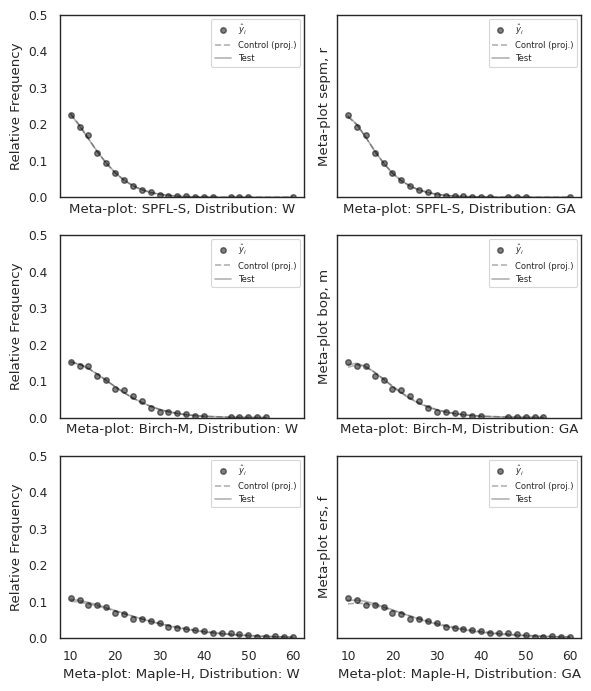

In [17]:
import scipy.stats.distributions as distributions
bootstrap = False
use_sigma = True
absolute_sigma = False
bounds = (0., np.inf)
max_nfev = 10000

fig, ax = plt.subplots(3, 2, figsize=(6, 7), sharey=True, sharex=True)
distns = [('w', (D['sb2']['w'], D['st']['w'])), 
          ('ga', (D['sb2']['ga'], D['st']['ga']))]
mplots = [('sepm', 'r'), ('bop', 'm'), ('ers', 'f')]
compile_stderr = True
plot_stderr = True
ylim = (0., 0.5)
expand_data = True
results = {}
out_flds = ['species',
            'covertype',
            'samplesize',
            'distribution',
            'chisqr1', 'chisqr2']
out_data = {fld:[] for fld in out_flds}
for i, v in enumerate(mplots):
    sg, ct = v
    results[v] = {}
    for j, (dn, (fit_func1, fit_func2)) in enumerate(distns):
        _df = df.loc[sg].loc[ct]
        xdata, ydata2, bins, stderrs = compile_bin_data(_df, compile_stderr=compile_stderr)
        xdata, ydata2, stderrs = zip(*[(x, y, stderr) for x, y, stderr in zip(xdata, ydata2, stderrs) if y > 0])
        xdata = np.array(xdata)
        #ydata1 = np.array(ydata1)
        ydata2 = np.array(ydata2)
        ydata1 = transform_data(xdata, ydata2, compression_factor)
        _sigma = expansion_factor(xdata)
        _sigma = _sigma / sum(_sigma)
        sigma = _sigma if use_sigma else None
        r = fit_and_plot(ax=ax[i][j],
                         fit_func1=fit_func1, 
                         fit_func2=fit_func2,
                         xdata=xdata, 
                         ydata1=ydata1, 
                         ydata2=ydata2, 
                         bins=bins,
                         bounds=bounds,
                         sigma=sigma,
                         absolute_sigma=absolute_sigma,
                         ylim=ylim,
                         max_nfev=max_nfev,
                         expand_data=expand_data)
        mr1, mr2 = r
        results[v][dn] = r
        sgs = species_group_names[sg]
        cts = cover_type_names_short[ct]
        dns = dist_names_long[dn]
        ax[i][j].set_ylabel('Meta-plot %s, %s' % (sg, ct))
        ax[i][0].set_ylabel('Relative Frequency')
        ax[i][j].set_xlabel('Meta-plot: %s-%s, Distribution: %s' % (sgs, cts, dns))
        sample_size = len(_df)
        out_data['species'].append(sgs)
        out_data['covertype'].append(cts)
        out_data['distribution'].append(dns)
        out_data['samplesize'].append(sample_size)
        out_data['chisqr1'].append(mr1.chisqr)
        out_data['chisqr2'].append(mr2.chisqr)        
plt.tight_layout()
#plt.savefig(data_path + 'dbhdistfit_method-hpsdata.pdf', format='pdf')

Print out results in $\LaTeX$ tabular format.

In [18]:
df_out = pd.DataFrame(out_data)[out_flds]
df_out

,species,covertype,samplesize,distribution,chisqr1,chisqr2
0,SPFL,S,6115,W,4.917945e-09,0.000033
1,SPFL,S,6115,GA,4.492844e-09,0.000028
2,Birch,M,1605,W,5.882437e-08,0.000081
3,Birch,M,1605,GA,5.696895e-08,0.000122
4,Maple,H,1290,W,7.466788e-08,0.000070
5,Maple,H,1290,GA,8.409193e-08,0.000108
